In [ ]:
!pip install CoolProp
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 17.9 MB/s eta 0:00:00


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em Watts
delta_T = 5  # Diferença de temperatura no trocador cascata
T_cond = 50 + 273.15  # Temperatura de condensação
efi = 0.7 # Eficiência Isentrópica do Compressor
T_evap = -25 + 273.15 # Temperatura de evaporação

# Restrições
Psep_min = 58427     # Psep precisa ser maior que 106399 Pa
Psep_max = 750000    # Psep não pode ser maior que P6 (será ajustado dinamicamente)

P6_min = Psep_min     # P6 precisa ser maior que Psep, então começa do mínimo de Psep
P6_max = 750000      # P6 não pode ser maior que 0.75 MPa


# Função para calcular COP, UA e outras variáveis de desempenho
def calcular_COP_e_UA(Psep, P6):
    # Estado 1 (entrada do compressor inferior 1)
    Temperatura_1 = -25 + 273.15  # -25°C
    h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
    s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
    P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)

    # Estado 2 (saída do compressor inferior 1)
    h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
    h_2 = ((h_2s-h_1)/efi) + h_1
    s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)

    # Estado 3 (líquido saturado após separador)
    h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)

    # Estado 4 (saída da válvula inferior 1)
    h_4 = h_3

    # Estado 5 (vapor saturado depois do separador)
    h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
    s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)

    # Estado 6 (saída do compressor inferior 2)
    h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
    h_6 = ((h_6s-h_5)/efi) + h_5
    s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
    Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)

    # Estado 7 (líquido saturado saindo do trocador cascata)
    h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
    Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)

    # Estado 8 (saída da válvula 2)
    h_8 = h_7

    # Estado 9 (entrada do compressor superior)
    Temperatura_9 = Temperatura_7 - delta_T
    h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
    s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
    P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)

    # Estado 11 (saída do condensador)
    P_11 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
    h_11 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

    # Estado 10 (saída do compressor superior)
    h_10s = CP.PropsSI('H', 'P', P_11, 'S', s_9, refri1)
    h_10 = ((h_10s-h_9)/efi) + h_9
    s_10 = CP.PropsSI('S', 'P', P_11, 'H', h_10, refri1)

    # Estado 12 (saída da válvula de expansão superior)
    h_12 = h_11
    Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)

    # Cálculo das vazões mássicas e do trabalho
    m1 = carga_termica / (h_1 - h_4)
    m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
    m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
    w1 = m1 * (h_2 - h_1)
    w2 = m2 * (h_6 - h_5)
    w3 = m3 * (h_10 - h_9)

    # Cálculo do COP
    COP = carga_termica / (w1 + w2 + w3)

    # Cálculo do LMTD (diferença de temperatura média logarítmica)
    delta_T_m = (((Temperatura_6 - Temperatura_12) - (Temperatura_7 - Temperatura_9)) /
                 np.log((Temperatura_6 - Temperatura_12) / (Temperatura_7 - Temperatura_9)))

    # Cálculo de Q
    Q = m3 * (h_9 - h_12)  # Calor trocado no ciclo superior

    # Cálculo de UA
    UA = Q / delta_T_m

    return COP, UA

# Função objetivo para o PSO
def funcao_objetivo(x):
    Psep, P6 = x[:, 0], x[:, 1]
    COP_valores = np.array([-calcular_COP_e_UA(Psep[i], P6[i])[0] for i in range(len(Psep))])
    return COP_valores

# Configuração do PSO
limites = (np.array([Psep_min, P6_min]), np.array([Psep_max, P6_max]))
opcoes = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=15, dimensions=2, options=opcoes, bounds=limites)

# Execução do PSO
melhor_custo, melhor_posicao = optimizer.optimize(funcao_objetivo, iters=40)

# Resultados
Psep_otimizado, P6_otimizado = melhor_posicao
COP_otimizado, UA_otimizado = calcular_COP_e_UA(Psep_otimizado, P6_otimizado)

# Exibição dos resultados
print(f"Valores ótimos encontrados:")
print(f"Psep = {Psep_otimizado / 1000:.2f} kPa")
print(f"P6 = {P6_otimizado / 1000:.2f} kPa")
print(f"COP otimizado = {COP_otimizado:.4f}")
print(f"UA correspondente = {UA_otimizado:.4f} W/K")

2025-02-16 21:39:11,243 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=-1.84
2025-02-16 21:39:13,973 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.8383880637092187, best pos: [161132.99021913 350166.16504381]


Valores ótimos encontrados:
Psep = 161.13 kPa
P6 = 350.17 kPa
COP otimizado = 1.8384
UA correspondente = 365.8029 W/K


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np

### SEPARADOR NO INFERIOR, NADA NO SUPERIOR

# Parâmetros do sistema de refrigeração
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
tl = -16 + 273.15
efi = 0.7
Psep = 161130
P6 = 750000

# Dados do estado "0"
t0 = 30 + 273.15  # Temperatura ambiente em K
h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)

# Ponto 1
Temperatura_1 = -25 + 273.15  # -25°C
P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))
# Ponto 2
h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
h_2 = ((h_2s-h_1)/efi) + h_1
s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)
af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))
# Ponto 3
h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)
s_3 = CP.PropsSI('S', 'P', Psep, 'Q', 0, refri2)
af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))
# Ponto 4
h_4 = h_3
P_4 = P_1
s_4 = CP.PropsSI('S', 'P', P_4, 'H', h_4, refri2)
af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))
# Ponto 5
h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)
af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))
# Ponto 6
h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
h_6 = ((h_6s-h_5)/efi) + h_5
s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)
af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))
# Ponto 7
h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
s_7 = CP.PropsSI('S', 'P', P6, 'Q', 0, refri2)
Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)
af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))
# Ponto 8
h_8 = h_7
s_8 = CP.PropsSI('S', 'P', Psep, 'H', h_8, refri2)
af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))
# Ponto 9
Temperatura_9 = Temperatura_7 - delta_T
h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))
# Ponto 11
P_11 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
h_11 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
s_11 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))
# Ponto 10
h_10s = CP.PropsSI('H', 'P', P_11, 'S', s_9, refri1)
h_10 = ((h_10s-h_9)/efi) + h_9
s_10 = CP.PropsSI('S', 'P', P_11, 'H', h_10, refri1)
af10 = (h_10- h0_1) - (t0 * (s_10 - s0_1))
# Ponto 12
h_12 = h_11
s_12 = CP.PropsSI('S', 'P', P_9, 'H', h_12, refri1)
Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)
af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))
x12 = CP.PropsSI('Q', 'P', P_9, 'H', h_12, refri1)

# Cálculo das vazões mássicas e do trabalho
m1 = carga_termica / (h_1 - h_4)
m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
w1 = m1 * (h_2 - h_1)
w2 = m2 * (h_6 - h_5)
w3 = m3 * (h_10 - h_9)

# Cálculo do COP
COP = carga_termica / (w1 + w2 + w3)

# Destruicoes de exergia
ADComp1 = (m1*af1)+w1-(m1*af2)
ADValv1 = m1*(af3-af4)
ADEvap = (m1*af4)+(carga_termica*(1-(t0/tl)))-(m1*af1)
ADComp2 = (m2*af5)+w2-(m2*af6)
ADValv2 = m2*(af7-af8)
ADTrocCasc = (m2 * (af6 - af7)) + (m3 * (af12 - af9))
ADComp3 = (m3*af9)+w3-(m3*af10)
ADCond = m3*(af10-af11)
ADValv3 = m3*(af11-af12)
ADSep = m1*(af2-af3)+m2*(af8-af5)

# Informações do ciclo
ADTotal = (w1+w2+w3)+(carga_termica*(1-(t0/tl)))
th = t0
COPteorico = tl / (th - tl)
N2 = COP / COPteorico

# Calculo do LMTD (diferença de temperatura média logarítmica)
delta_T_m = (((Temperatura_6 - Temperatura_12) - (Temperatura_7 - Temperatura_9)) /
np.log((Temperatura_6 - Temperatura_12) / (Temperatura_7 - Temperatura_9)))

# Cálculo de Q
Q = m3 * (h_9 - h_12)  # Calor trocado no ciclo superior

# Cálculo de UA
UA = Q / delta_T_m

print(x12)

0.008254728959547122


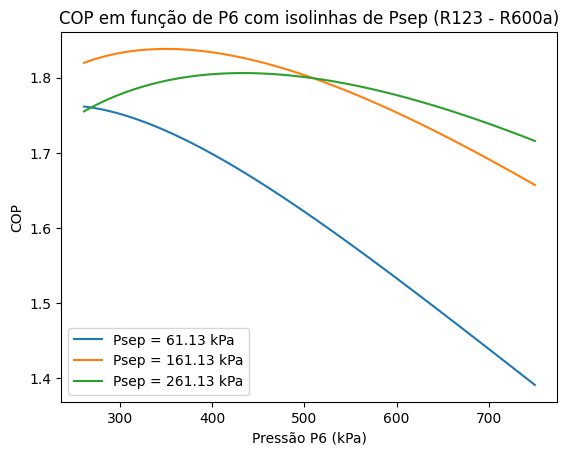

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7

# Valores de Psep para as isolinhas
valores_de_Psep = [61130, 161130, 261130]

# Intervalo de valores de P6
valores_de_P6 = np.linspace(261130, 750000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for Psep in valores_de_Psep:
    valores_COP = []
    pressoes_p6 = []

    # Loop para diferentes valores de P6
    for P6 in valores_de_P6:
        # Estado 1 (entrada do compressor inferior 1)
        Temperatura_1 = -25 + 273.15  # -25°C
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)

        # Estado 2 (saída do compressor inferior 1)
        h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
        h_2 = ((h_2s-h_1)/efi) + h_1
        s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)

        # Estado 3 (líquido saturado após separador)
        h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)

        # Estado 4 (saída da válvula inferior 1)
        h_4 = h_3

        # Estado 5 (vapor saturado depois do separador)
        h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)

        # Estado 6 (saída do compressor inferior 2)
        h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
        h_6 = ((h_6s-h_5)/efi) + h_5
        s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)

        # Estado 7 (líquido saturado saindo do trocador cascata)
        h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)

        # Estado 8 (saída da válvula 2)
        h_8 = h_7

        # Estado 9 (entrada do compressor superior)
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)

        # Estado 11 (saída do condensador)
        P_11 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        h_11 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

        # Estado 10 (saída do compressor superior)
        h_10s = CP.PropsSI('H', 'P', P_11, 'S', s_9, refri1)
        h_10 = ((h_10s-h_9)/efi) + h_9
        s_10 = CP.PropsSI('S', 'P', P_11, 'H', h_10, refri1)

        # Estado 12 (saída da válvula de expansão superior)
        h_12 = h_11
        Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)

        # Cálculo das vazões mássicas e do trabalho
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_10 - h_9)

        # Cálculo do COP
        COP = carga_termica / (w1 + w2 + w3)

        # Armazenar os resultados para plotagem
        valores_COP.append(COP)
        pressoes_p6.append(P6 / 1e3)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_COP, label=f'Psep = {Psep / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P6 (kPa)')
plt.ylabel('COP')
plt.title('COP em função de P6 com isolinhas de Psep (R123 - R600a)')
plt.legend()
plt.grid(False)
plt.show()

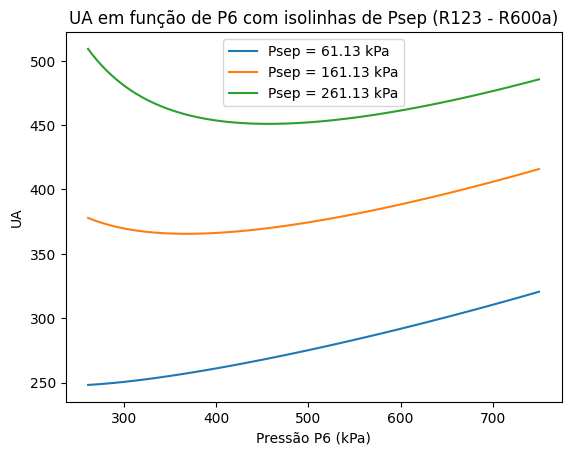

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
tl = -16+273.15

# Valores de Psep para as isolinhas
valores_de_Psep = [61130, 161130, 261130]

# Intervalo de valores de P6
valores_de_P6 = np.linspace(261130, 750000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for Psep in valores_de_Psep:
    valores_UA = []
    pressoes_p6 = []

    # Loop para diferentes valores de P6
    for P6 in valores_de_P6:
        Temperatura_1 = -25 + 273.15  # -25°C
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)

        # Estado 2 (saída do compressor inferior 1)
        h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
        h_2 = ((h_2s-h_1)/efi) + h_1
        s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)

        # Estado 3 (líquido saturado após separador)
        h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)

        # Estado 4 (saída da válvula inferior 1)
        h_4 = h_3

        # Estado 5 (vapor saturado depois do separador)
        h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)

        # Estado 6 (saída do compressor inferior 2)
        h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
        h_6 = ((h_6s-h_5)/efi) + h_5
        s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
        Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)

        # Estado 7 (líquido saturado saindo do trocador cascata)
        h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)

        # Estado 8 (saída da válvula 2)
        h_8 = h_7

        # Estado 9 (entrada do compressor superior)
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)

        # Estado 11 (saída do condensador)
        P_11 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        h_11 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)

        # Estado 10 (saída do compressor superior)
        h_10s = CP.PropsSI('H', 'P', P_11, 'S', s_9, refri1)
        h_10 = ((h_10s-h_9)/efi) + h_9
        s_10 = CP.PropsSI('S', 'P', P_11, 'H', h_10, refri1)

        # Estado 12 (saída da válvula de expansão superior)
        h_12 = h_11
        Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)

        # Cálculo das vazões mássicas e do trabalho
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_10 - h_9)

        # Calculo do LMTD (diferença de temperatura média logarítmica)
        delta_T_m = (((Temperatura_6 - Temperatura_12) - (Temperatura_7 - Temperatura_9)) /
        np.log((Temperatura_6 - Temperatura_12) / (Temperatura_7 - Temperatura_9)))

        # Cálculo de Q
        Q = m3 * (h_9 - h_12)  # Calor trocado no ciclo superior

        # Cálculo de UA
        UA = Q / delta_T_m

        # Armazenar os resultados para plotagem
        valores_UA.append(UA)
        pressoes_p6.append(P6 / 1e3)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_UA, label=f'Psep = {Psep / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P6 (kPa)')
plt.ylabel('UA')
plt.title('UA em função de P6 com isolinhas de Psep (R123 - R600a)')
plt.legend()
plt.grid(False)
plt.show()